In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

In [2]:
from data_analysis import Dataset

In [3]:
run_label = '20210707' ## Change this to look at different runs
d = Dataset(run_label=run_label, gases=['O2', 'CO2'])

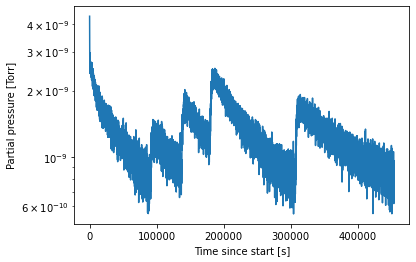

In [4]:
d.GetData()
d.FindPeaks()
d.GetRanges()
d.PlotSingleGas('O2')

## Fitting each peak individually

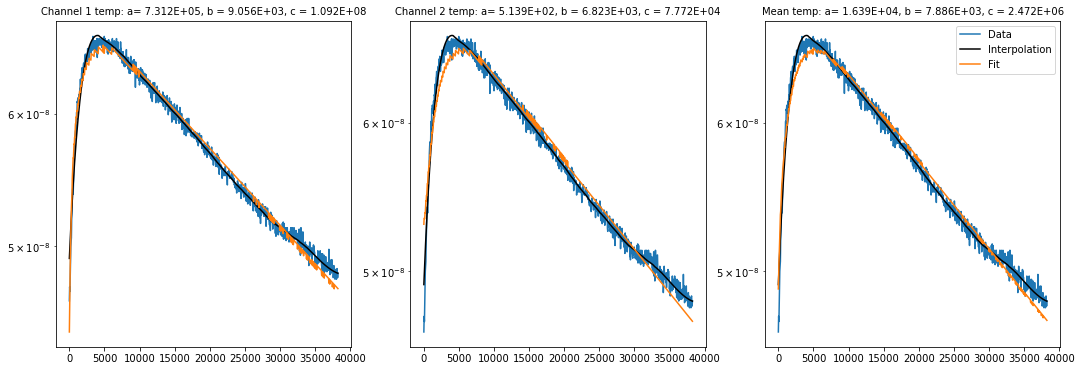

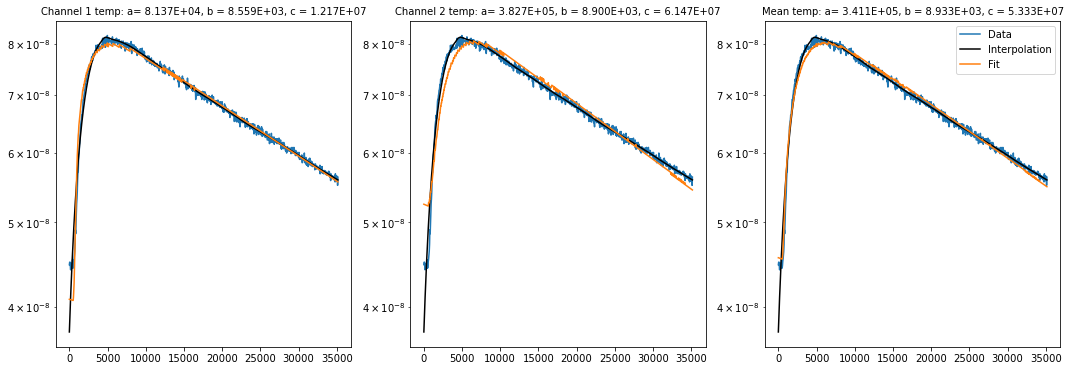

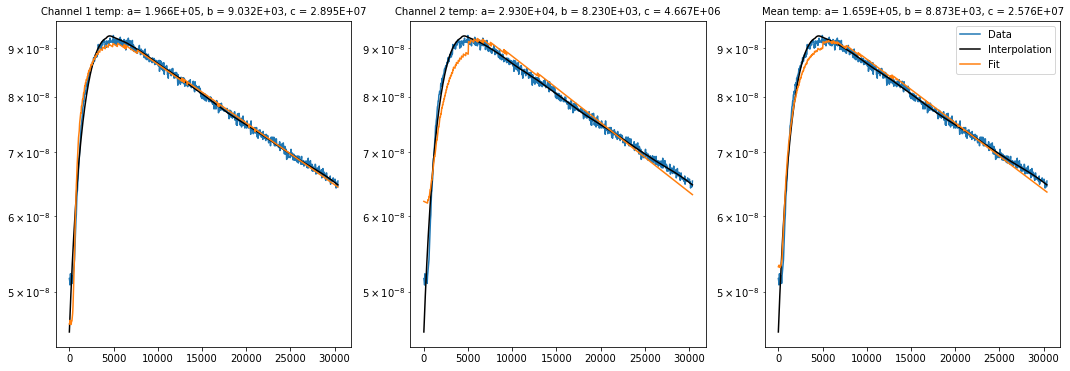

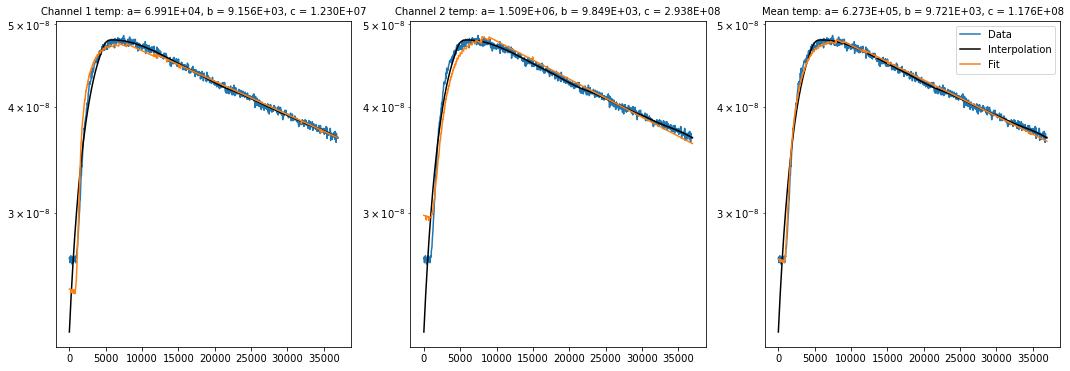

In [5]:
import warnings
warnings.filterwarnings("ignore")
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d


a_range = np.arange(0, 10000, 1000)
b_range = np.arange(0, 10000, 1000)
for i,gas in enumerate(d.gases):
    if gas =='O2':
        continue
    for j, fitrange in enumerate(d.range[gas]):
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
        
        if j < 2:
            time_offset = np.array(d.data[gas]['exp_time'])[fitrange[0]]
            xdata = np.array(d.data[gas]['exp_time'])[fitrange[0]:fitrange[1]] - time_offset
            ydata = np.array(d.data[gas]['pressure'])[fitrange[0]:fitrange[1]]
            temp1 = np.array(d.data[gas]['ch1_lerp'])[fitrange[0]:fitrange[1]]
            temp2 = np.array(d.data[gas]['ch2_lerp'])[fitrange[0]:fitrange[1]]
            sample_temp = np.array(d.data[gas]['mean_temp'])[fitrange[0]:fitrange[1]]
        elif j < (len(d.range[gas]) - 1) :
            time_offset = np.array(d.data[gas]['exp_time'])[fitrange[0]]
            xdata = np.array(d.data[gas]['exp_time'])[fitrange[0]:int(fitrange[0]+(fitrange[1]-fitrange[0])/4)] - time_offset
            ydata = np.array(d.data[gas]['pressure'])[fitrange[0]:int(fitrange[0]+(fitrange[1]-fitrange[0])/4)]
            temp1 = np.array(d.data[gas]['ch1_lerp'])[fitrange[0]:int(fitrange[0]+(fitrange[1]-fitrange[0])/4)]
            temp2 = np.array(d.data[gas]['ch2_lerp'])[fitrange[0]:int(fitrange[0]+(fitrange[1]-fitrange[0])/4)]
            sample_temp = np.array(d.data[gas]['mean_temp'])[fitrange[0]:int(fitrange[0]+(fitrange[1]-fitrange[0])/4)]
        else:
            time_offset = np.array(d.data[gas]['exp_time'])[fitrange[0]]
            xdata = np.array(d.data[gas]['exp_time'])[fitrange[0]:int(fitrange[0]+
                                                                      (len(d.data[gas]['exp_time'])-1-fitrange[0])/4)] - time_offset
            ydata = np.array(d.data[gas]['pressure'])[fitrange[0]:int(fitrange[0]+
                                                                      (len(d.data[gas]['pressure'])-1-fitrange[0])/4)]
            temp1 = np.array(d.data[gas]['ch1_lerp'])[fitrange[0]:int(fitrange[0]+
                                                                      (len(d.data[gas]['ch1_lerp'])-1-fitrange[0])/4)]
            temp2 = np.array(d.data[gas]['ch2_lerp'])[fitrange[0]:int(fitrange[0]+
                                                                      (len(d.data[gas]['ch2_lerp'])-1-fitrange[0])/4)]
            sample_temp = np.array(d.data[gas]['mean_temp'])[fitrange[0]:int(fitrange[0]+
                                                                             (len(d.data[gas]['mean_temp'])-1-fitrange[0])/4)]

        # interpolation to smooth out the noise
        xx = np.linspace(xdata.min(),xdata.max(), len(xdata))
        itp = interp1d(xdata,ydata, kind='linear')
        window_size, poly_order = 201, 3
        yy_sg = savgol_filter(itp(xx), window_size, poly_order)

        
        for ax in axes:
            ax.plot(xdata,ydata, label='Data')
            ax.plot(xx,yy_sg, label='Interpolation', c='k')
            ax.set_yscale('log')

        
        i=1
        popt_list_t1 = []
        popt_list_t2 = []
        popt_list_tm = []
        chi_list_t1 = []
        chi_list_t2 = []
        chi_list_tm = []
        for x in a_range:
            for y in b_range:
                i += 1
                #a, b = fsolve(constraint_eq, (x, y))
                try:
                    #fits for the temperature from the first channel:
                    popt1,pcov1 = curve_fit(d.fitfunction, [xdata,temp1], ydata, p0=[x, y, 0.005])
                    fit1 = d.fitfunction([xdata,temp1], *popt1)
                    chi_data1 = np.sum((fit1 - ydata)**2 / fit1)
                    popt_list_t1.append(popt1)
                    chi_list_t1.append(chi_data1)
                    
                    #fits for the temperature from the second channel:
                    popt2,pcov2 = curve_fit(d.fitfunction, [xdata,temp2], ydata, p0=[x, y, 0.005])
                    fit2 = d.fitfunction([xdata,temp2], *popt2)
                    chi_data2 = np.sum((fit2 - ydata)**2 / fit2)
                    popt_list_t2.append(popt2)
                    chi_list_t2.append(chi_data2)
                    
                    #fits for the mean temperature:
                    poptm,pcovm = curve_fit(d.fitfunction, [xdata,sample_temp], ydata, p0=[x, y, 0.005])
                    fitm = d.fitfunction([xdata,sample_temp], *poptm)
                    chi_datam = np.sum((fitm - ydata)**2 / fitm)
                    popt_list_tm.append(poptm)
                    chi_list_tm.append(chi_datam)
                except:
                    pass
        #converting the lists to arrays
        popt_list_t1 = np.array(popt_list_t1)
        chi_list_t1 = np.array(chi_list_t1)
        popt_list_t2 = np.array(popt_list_t2)
        chi_list_t2 = np.array(chi_list_t2)
        popt_list_tm = np.array(popt_list_tm)
        chi_list_tm = np.array(chi_list_tm)
        
        #finding the fit with the lowest chi-squared value
        pfit_t1 = popt_list_t1[np.where(chi_list_t1==np.min(chi_list_t1))]
        pfit_t2 = popt_list_t2[np.where(chi_list_t2==np.min(chi_list_t2))]
        pfit_tm = popt_list_tm[np.where(chi_list_tm==np.min(chi_list_tm))]
        
        #plotting the fits against the data and interpolation
        axes[0].plot(xdata, d.fitfunction([xdata,temp1], *pfit_t1[0]), label='Fit')
        axes[1].plot(xdata, d.fitfunction([xdata,temp2], *pfit_t2[0]), label='Fit')
        axes[2].plot(xdata, d.fitfunction([xdata,sample_temp], *pfit_tm[0]), label='Fit')
        
        axes[0].set_title('Channel 1 temp: a= {:.3E}, b = {:.3E}, c = {:.3E}'.format(pfit_t1[0][0], pfit_t1[0][1],
                                                                                     pfit_t1[0][2]), fontsize=10)
        axes[1].set_title('Channel 2 temp: a= {:.3E}, b = {:.3E}, c = {:.3E}'.format(pfit_t2[0][0], pfit_t2[0][1],
                                                                                     pfit_t2[0][2]), fontsize=10)
        axes[2].set_title('Mean temp: a= {:.3E}, b = {:.3E}, c = {:.3E}'.format(pfit_tm[0][0], pfit_tm[0][1],
                                                                                     pfit_tm[0][2]), fontsize=10)
        plt.legend(loc='upper right')
        #plt.savefig('{}_peakfit.png'.format(sample_temp[0]))
        plt.show()

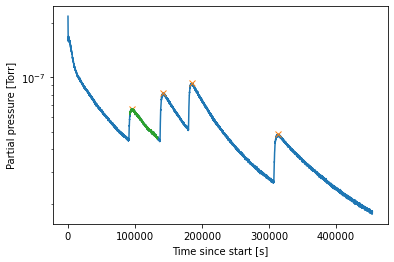

In [8]:
gas = 'CO2'
d.PlotSingleGas(gas)
plt.plot(np.array(d.data[gas]['exp_time'])[d.peak_indices[gas]], 
         np.array(d.data[gas]['pressure'])[d.peak_indices[gas]], 'x')
plt.plot(np.array(d.data[gas]['exp_time'])[d.peak_indices[gas][0]-80:d.peak_indices[gas][1]-200], 
         np.array(d.data[gas]['pressure'])[d.peak_indices[gas][0]-80:d.peak_indices[gas][1]-200], 
         ls='-')

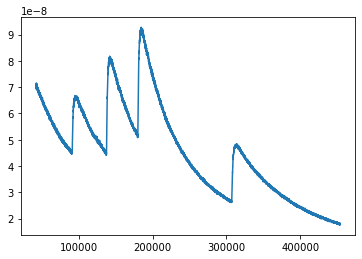

In [9]:
gas = 'CO2'
# d.PlotSingleGas(gas)
plt.plot(np.array(d.data[gas]['exp_time'])[1000:], 
         np.array(d.data[gas]['pressure'])[1000:])
# plt.plot(np.array(d.data[gas]['exp_time'])[d.peak_indices[gas][0]-80:d.peak_indices[gas][1]-200], 
#          np.array(d.data[gas]['pressure'])[d.peak_indices[gas][0]-80:d.peak_indices[gas][1]-200], 
#          ls='-')

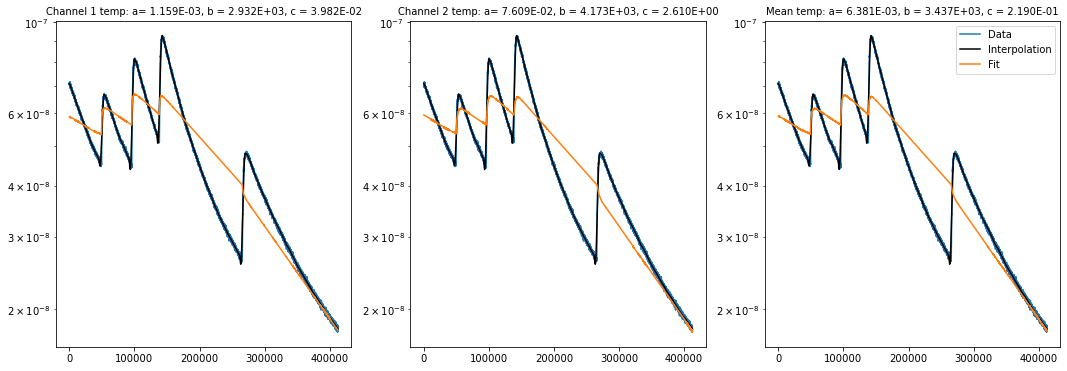

In [10]:
##this takes a while to run, so eventually it might be good to try to optimize how this is running
##I might start with coarser binning for the parameter scans
c_range = np.arange(0, 100000, 10000)
for i,gas in enumerate(d.gases):
    if gas =='O2':
        continue
    xoffset = np.array(d.data[gas]['exp_time'])[1000]
    xdata = np.array(d.data[gas]['exp_time'])[1000:]-xoffset#d.range[gas][1][1]]-xoffset
    ydata = np.array(d.data[gas]['pressure'])[1000:]#d.range[gas][1][1]]
    temp1 = np.array(d.data[gas]['ch1_lerp'])[1000:]#d.range[gas][1][1]]
    temp2 = np.array(d.data[gas]['ch2_lerp'])[1000:]#d.range[gas][1][1]]
    sample_temp = np.array(d.data[gas]['mean_temp'])[1000:]#d.range[gas][1][1]]
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

    # interpolation to smooth out the noise
    xx = np.linspace(xdata.min(),xdata.max(), len(xdata))
    itp = interp1d(xdata,ydata, kind='linear')
    window_size, poly_order = 201, 3
    yy_sg = savgol_filter(itp(xx), window_size, poly_order)

    
    for ax in axes:
        ax.plot(xdata,ydata, label='Data')
        ax.plot(xx,yy_sg, label='Interpolation', c='k')
        ax.set_yscale('log')
    
    
    i=1
    popt_list_t1 = []
    popt_list_t2 = []
    popt_list_tm = []
    chi_list_t1 = []
    chi_list_t2 = []
    chi_list_tm = []
    #scanning through a range of possible parameter values to find the best fit via minimizing the chi-squared value
    for x in a_range:
        for y in b_range:
            for z in c_range:
                i += 1
                #a, b = fsolve(constraint_eq, (x, y))
                try:
                    #fits for the temperature from the first channel:
                    popt1,pcov1 = curve_fit(d.fitfunction, [xdata,temp1], ydata, p0=[x, y, z])
                    fit1 = d.fitfunction([xdata,temp1], *popt1)
                    chi_data1 = np.sum((fit1 - ydata)**2 / fit1)
                    popt_list_t1.append(popt1)
                    chi_list_t1.append(chi_data1)
                    
                    #fits for the temperature from the second channel:
                    popt2,pcov2 = curve_fit(d.fitfunction, [xdata,temp2], ydata, p0=[x, y, z])
                    fit2 = d.fitfunction([xdata,temp2], *popt2)
                    chi_data2 = np.sum((fit2 - ydata)**2 / fit2)
                    popt_list_t2.append(popt2)
                    chi_list_t2.append(chi_data2)
                    
                    #fits for the mean temperature:
                    poptm,pcovm = curve_fit(d.fitfunction, [xdata,sample_temp], ydata, p0=[x, y, z])
                    fitm = d.fitfunction([xdata,sample_temp], *poptm)
                    chi_datam = np.sum((fitm - ydata)**2 / fitm)
                    popt_list_tm.append(poptm)
                    chi_list_tm.append(chi_datam)
                except:
                    pass
    
    #converting the lists to arrays
    popt_list_t1 = np.array(popt_list_t1)[np.array(chi_list_t1) > 0]
    chi_list_t1 = np.array(chi_list_t1)[np.array(chi_list_t1) > 0]
    popt_list_t2 = np.array(popt_list_t2)[np.array(chi_list_t2) > 0]
    chi_list_t2 = np.array(chi_list_t2)[np.array(chi_list_t2) > 0]
    popt_list_tm = np.array(popt_list_tm)[np.array(chi_list_tm) > 0]
    chi_list_tm = np.array(chi_list_tm)[np.array(chi_list_tm) >0]

    #finding the fit with the lowest chi-squared value
    pfit_t1 = popt_list_t1[np.where(chi_list_t1==np.min(chi_list_t1))]
    pfit_t2 = popt_list_t2[np.where(chi_list_t2==np.min(chi_list_t2))]
    pfit_tm = popt_list_tm[np.where(chi_list_tm==np.min(chi_list_tm))]
    
    #doing a secondary scan around the 
    
    #plotting the fits against the data and interpolation
    axes[0].plot(xdata, d.fitfunction([xdata,temp1], *pfit_t1[0]), label='Fit')
    axes[1].plot(xdata, d.fitfunction([xdata,temp2], *pfit_t2[0]), label='Fit')
    axes[2].plot(xdata, d.fitfunction([xdata,sample_temp], *pfit_tm[0]), label='Fit')

    axes[0].set_title('Channel 1 temp: a= {:.3E}, b = {:.3E}, c = {:.3E}'.format(pfit_t1[0][0], pfit_t1[0][1],
                                                                                 pfit_t1[0][2]), fontsize=10)
    axes[1].set_title('Channel 2 temp: a= {:.3E}, b = {:.3E}, c = {:.3E}'.format(pfit_t2[0][0], pfit_t2[0][1],
                                                                                 pfit_t2[0][2]), fontsize=10)
    axes[2].set_title('Mean temp: a= {:.3E}, b = {:.3E}, c = {:.3E}'.format(pfit_tm[0][0], pfit_tm[0][1],
                                                                                     pfit_tm[0][2]), fontsize=10)
    plt.legend(loc='upper right')
    #plt.savefig('{}_peakfit.png'.format(sample_temp[0]))
    plt.show()